In [ ]:
#default_exp constraints

# Battery Constraints

The solution must meet constraints of the battery:

- Must only charge between 00:00-15:30
- Must only discharge between 15:30--21:00
- Must not charge or discharge between 21:00--00:00
- Battery must be empty at 00:00 each day

<br>

### Imports

In [ ]:
#exports
import numpy as np
import pandas as pd

<br>

### Loading an Example Charging Rate Profile

In [ ]:
df_charge_rate = pd.read_csv('../data/output/latest_submission.csv')

s_charge_rate = df_charge_rate.set_index('datetime')['charge_MW']
s_charge_rate.index = pd.to_datetime(s_charge_rate.index)

s_charge_rate.head()

datetime
2018-07-23 00:00:00+00:00    0.0
2018-07-23 00:30:00+00:00    0.0
2018-07-23 01:00:00+00:00    0.0
2018-07-23 01:30:00+00:00    0.0
2018-07-23 02:00:00+00:00    0.0
Name: charge_MW, dtype: float64

<br>

### Checking for Nulls

Before we start doing anything clever we'll do a simple check for null values

In [ ]:
#exports
def check_for_nulls(s_charge_rate):
    assert s_charge_rate.isnull().sum()==0, 'There are null values in the charge rate time-series'

In [ ]:
check_for_nulls(s_charge_rate)

<br>

### Converting a charging schedule to capacity

The solution is given in terms of the battery charge/discharge schedule, but it is also necessary to satisfy constraints on the capacity of the battery (see below). 

The charge is determined by $C_{t+1} = C_{t} + 0.5B_{t}$

We'll start by generating the charge state time-series

In [ ]:
#exports
def construct_charge_state_s(s_charge_rate: pd.Series, time_unit: float=0.5) -> pd.Series:
    s_charge_state = (s_charge_rate
                      .cumsum()
                      .divide(1/time_unit)
                     )
    
    return s_charge_state

<AxesSubplot:xlabel='datetime'>

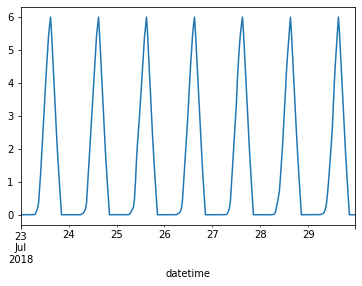

In [ ]:
s_charge_state = construct_charge_state_s(s_charge_rate)

s_charge_state.plot()

<br>

### Checking Capacity Constraints

$0 \leq C \leq C_{max}$

We'll confirm that the bounds of the values in the charging time-series do not fall outside of the 0-6 MWh capacity of the battery

In [ ]:
#exports
doesnt_exceed_charge_state_min = lambda s_charge_state, min_charge=0: (s_charge_state.round(10)<min_charge).sum()==0
doesnt_exceed_charge_state_max = lambda s_charge_state, max_charge=6: (s_charge_state.round(10)>max_charge).sum()==0

def check_capacity_constraints(s_charge_state, min_charge=0, max_charge=6):
    assert doesnt_exceed_charge_state_min(s_charge_state, min_charge), 'The state of charge falls below 0 MWh which is beyond the bounds of possibility'
    assert doesnt_exceed_charge_state_max(s_charge_state, max_charge), 'The state of charge exceeds the 6 MWh capacity'
    
    return

In [ ]:
check_capacity_constraints(s_charge_state)

<br>

### Checking Full Utilisation

We'll also check that the battery falls to 0 MWh and rises to 6 MWh each day

In [ ]:
#exports
check_all_values_equal = lambda s, value=0: (s==0).mean()==1

charge_state_always_drops_to_0MWh = lambda s_charge_state, min_charge=0: s_charge_state.groupby(s_charge_state.index.date).min().round(10).pipe(check_all_values_equal, min_charge)
charge_state_always_gets_to_6MWh = lambda s_charge_state, max_charge=6: s_charge_state.groupby(s_charge_state.index.date).min().round(10).pipe(check_all_values_equal, max_charge)

def check_full_utilisation(s_charge_state, min_charge=0, max_charge=6):
    assert charge_state_always_drops_to_0MWh(s_charge_state, min_charge), 'The state of charge does not always drop to 0 MWh each day'
    assert charge_state_always_gets_to_6MWh(s_charge_state, max_charge), 'The state of charge does not always rise to 6 MWh each day'
    
    return 

In [ ]:
check_full_utilisation(s_charge_state)

<br>

### Checking Charge Rates

$B_{min} \leq B \leq B_{max}$ 

We'll then check that the minimum and maximum rates fall inside the -2.5 - 2.5 MW allowed by the battery

In [ ]:
#exports
doesnt_exceed_charge_rate_min = lambda s_charge_rate, min_rate=-2.5: (s_charge_rate.round(10)<min_rate).sum()==0
doesnt_exceed_charge_rate_max = lambda s_charge_rate, max_rate=2.5: (s_charge_rate.round(10)>max_rate).sum()==0

def check_rate_constraints(s_charge_rate, min_rate=-2.5, max_rate=2.5):
    assert doesnt_exceed_charge_rate_min(s_charge_rate, min_rate), 'The rate of charge falls below -2.5 MW limit'
    assert doesnt_exceed_charge_rate_max(s_charge_rate, max_rate), 'The rate of charge exceeds the 2.5 MW limit'
    
    return

In [ ]:
check_rate_constraints(s_charge_rate)

<br>

### Checking Charge/Discharge/Inactive Periods

We can only charge the battery between periods 1 (00:00) and 31 (15:00) inclusive, and discharge between periods 32 (15:30) and 42 (20:30) inclusive. For periods 43 to 48, there should be no activity, and the day must start with $C=0$. 

In [ ]:
#exports
charge_is_0_at_midnight = lambda s_charge_state: (s_charge_state.between_time('23:30', '23:59').round(10)==0).mean()==1
all_charge_periods_charge = lambda s_charge_rate, charge_times=('00:00', '15:00'): (s_charge_rate.between_time(charge_times[0], charge_times[1]).round(10) >= 0).mean() == 1
all_discharge_periods_discharge = lambda s_charge_rate, discharge_times=('15:30', '20:30'): (s_charge_rate.between_time(discharge_times[0], discharge_times[1]).round(10) <= 0).mean() == 1
all_inactive_periods_do_nothing = lambda s_charge_rate, inactive_times=('21:00', '23:30'): (s_charge_rate.between_time(inactive_times[0], inactive_times[1]).round(10) == 0).mean() == 1

def check_charging_patterns(s_charge_rate, s_charge_state, charge_times=('00:00', '15:00'), discharge_times=('15:30', '20:30'), inactive_times=('21:00', '23:30')):
    assert charge_is_0_at_midnight(s_charge_state), 'The battery is not always at 0 MWh at midnight'
    assert all_charge_periods_charge(s_charge_rate, charge_times), 'Some of the periods which should only be charging are instead discharging'
    assert all_discharge_periods_discharge(s_charge_rate, discharge_times), 'Some of the periods which should only be discharging are instead charging'
    assert all_inactive_periods_do_nothing(s_charge_rate, inactive_times), 'Some of the periods which should be doing nothing are instead charging/discharging'
    
    return

In [ ]:
check_charging_patterns(s_charge_rate, s_charge_state)

In [ ]:
#exports
def schedule_is_legal(s_charge_rate, time_unit=0.5, 
                      min_rate=-2.5, max_rate=2.5, 
                      min_charge=0, max_charge=6, 
                      charge_times=('00:00', '15:00'), 
                      discharge_times=('15:30', '20:30'),
                      inactive_times=('21:00', '23:30')):
    """
    Determine if a battery schedule meets the specified constraints
    """
    
    check_for_nulls(s_charge_rate)
    s_charge_state = construct_charge_state_s(s_charge_rate, time_unit)
    
    check_capacity_constraints(s_charge_state, min_charge, max_charge)
    check_full_utilisation(s_charge_state, min_charge, max_charge)
    check_rate_constraints(s_charge_rate, min_rate, max_rate)
    check_charging_patterns(s_charge_rate, s_charge_state, charge_times, discharge_times, inactive_times)
    
    return True

In [ ]:
schedule_is_legal(s_charge_rate)

True

<br>

Finally we'll export the relevant code to our `batopt` module

In [ ]:
#hide
from nbdev.export import notebook2script
    
notebook2script()

Converted 00-utilities.ipynb.
Converted 01-cleaning.ipynb.
Converted 02-discharging.ipynb.
Converted 03-charging.ipynb.
Converted 04-constraints.ipynb.
Converted 05-pipeline.ipynb.
